* 실습을 진행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 하드웨어 가속기로 선택한다.

### <b>WandB를 이용한 학습 및 평가 과정 로깅(Logging)</b>

* <b>WandB</b>는 기계학습/딥러닝 개발자를 위한 종합적인 보조 도구다.
* 가장 대표적인 기능으로는 우리가 딥러닝 모델을 학습할 때 학습 과정에 대해서 로깅(logging)을 진행해 준다.
* 그래서 손실(loss) 값의 감소하는 형태를 쉽게 파악할 수 있다.
* 특히 WandB는 팀 단위로 실험 결과를 추적할 수 있도록 해주기 때문에, 웹 상에서 보다 편리하게 분석이 가능하다.
* <b>WanDB 공식 홈페이지</b>: https://wandb.ai/

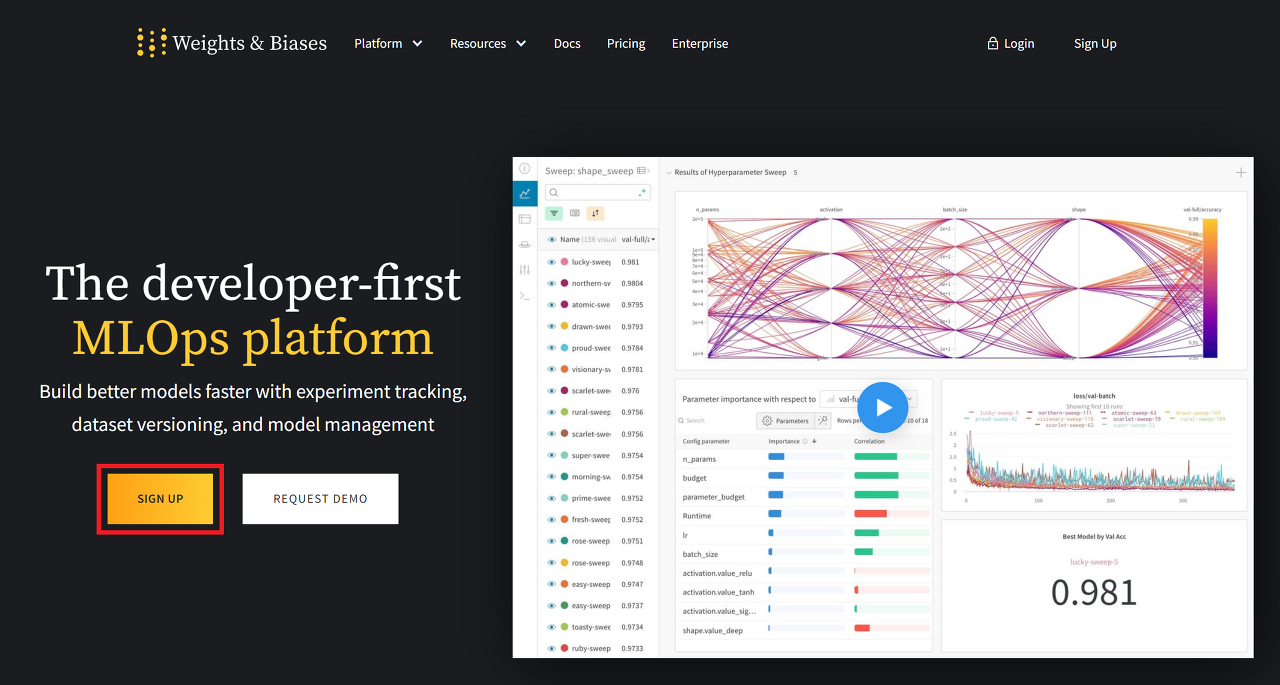

#### <b>WandB 예제 코드 사용해 보기</b>

* 가장 먼저 파이썬 패키지 매니저인 pip 명령어를 이용하여 wandb를 설치한다.


In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 23.9 MB/s 
     |████████████████████████████████| 182 kB 58.1 MB/s 
     |████████████████████████████████| 168 kB 57.4 MB/s 
     |████████████████████████████████| 62 kB 839 kB/s 
     |████████████████████████████████| 168 kB 76.6 MB/s 
     |████████████████████████████████| 166 kB 63.0 MB/s 
     |████████████████████████████████| 166 kB 64.6 MB/s 
     |████████████████████████████████| 162 kB 52.9 MB/s 
     |████████████████████████████████| 162 kB 61.7 MB/s 
     |████████████████████████████████| 158 kB 66.5 MB/s 
     |████████████████████████████████| 157 kB 62.7 MB/s 
     |████████████████████████████████| 157 kB 42.6 MB/s 
     |████████████████████████████████| 157 kB 61.5 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 58.8 MB/s 
     |███████████████████████████

#### <b>WandB 예제 코드 사용해 보기</b>

* 이후에 wandb login 명령어를 입력하여 로그인을 진행할 수 있다.
* 인증을 위해 본인의 <b>API Key</b>를 입력해야 할 수 있다.
  * wandb 웹 사이트에 로그인 이후에 등장하는 API Key를 복사하여 붙여넣기한다.
* <b>Settings</b>: https://wandb.ai/settings

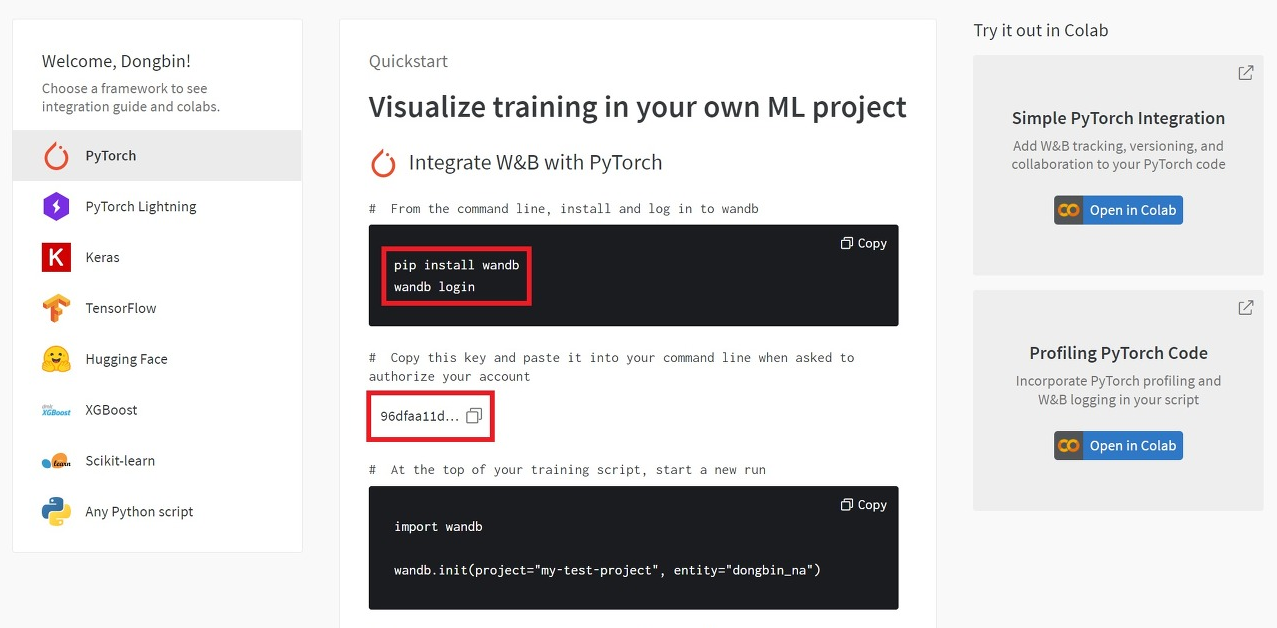

In [ ]:
!wandb login

#### <b>PyTorch 예제 코드를 통해 WandB 사용 방법 이해하기</b>

* PyTorch 공식 문서에서 제공하는 MNIST 학습 코드를 가져와 실행해 보자.
* <b>PyTorch 공식 MNIST 코드</b>: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [3]:
from types import SimpleNamespace
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main(args):
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

In [4]:
# Training settings
args = SimpleNamespace()
args.batch_size = 64 # input batch size for training
args.test_batch_size = 1000 # input batch size for testing
args.epochs = 14 # number of epochs to train
args.lr = 1 # learning rate
args.gamma = 0.7 # learning rate step gamma
args.no_cuda = False # disables CUDA training
args.dry_run = False # quickly check a single pass
args.seed = 1 # random seed
args.log_interval = 100 # how many batches to wait before logging training status
args.save_model = False # for Saving the current Model

main(args)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282550
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.297472
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.342867
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.164957
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.100257
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.168480
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.091361
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.071932
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.136255
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.052896

Test set: Average loss: 0.0463, Accuracy: 9850/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.116357
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.019374
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.074447
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.027940
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.108513
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.014242
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028732
Train Epoch: 2 [44800/60

#### <b>WandB 사용해보기</b>

* 앞서 사용했던 코드를 다음과 같이 <b>wandb 라이브러리</b>를 사용하는 형태로 바꿀 수 있다.
* 기본적으로 변경된 부분은 wandb가 포함된 부분이므로, 이 부분만을 확인하면 된다.

In [5]:
import wandb
from types import SimpleNamespace
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # wandb에 기록할 테스트 이미지들
    tested_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # wandb에 현재 배치에 포함된 첫 번째 이미지에 대한 추론 결과 기록
            tested_images.append(
                wandb.Image(data[0], caption=f'Predicted: {pred[0].item()}, Ground-truth: {target[0]}'
            ))

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # wandb에 로깅 진행
    wandb.log({
        "Tested Images": tested_images,
        "Test Average Loss": test_loss,
        "Test Accuarcy": 100. * correct / len(test_loader.dataset)
    })


def main(args):
    # wandb 프로젝트 초기화
    wandb.init(project='wandb-mnist-example', entity='dongbin_na')
    # wandb에 하이퍼파라미터 configuration 정보 기록
    wandb.config.update(args)

    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    # wandb에서 학습할 모델 정보 추적
    wandb.watch(model)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

In [6]:
# Training settings
args = SimpleNamespace()
args.batch_size = 64 # input batch size for training
args.test_batch_size = 1000 # input batch size for testing
args.epochs = 14 # number of epochs to train
args.lr = 1 # learning rate
args.gamma = 0.7 # learning rate step gamma
args.no_cuda = False # disables CUDA training
args.dry_run = False # quickly check a single pass
args.seed = 1 # random seed
args.log_interval = 100 # how many batches to wait before logging training status
args.save_model = False # for Saving the current Model

main(args)

wandb: Currently logged in as: dongbin_na. Use `wandb login --relogin` to force relogin


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282550
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.249408
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.248822
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.175573
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.126454
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.137142
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.086237
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.043724
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.096367
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.041973

Test set: Average loss: 0.0474, Accuracy: 9854/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.107286
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.033705
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.044127
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.042890
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071393
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.039878
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.022000
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.118852
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019050
T

#### <b>WandB 로그 확인하기</b>

* 참고로 코드를 실행한 폴더에도 wandb 관련 log 폴더가 생성된다.
  * 실행할 때마다 한 번의 run 폴더가 생긴다.
* 기본적으로 <b>wandb 서버</b>에 학습할 때의 <b>로그 데이터</b>가 모두 업로드 된다.
  * 웹 상에서 즉시 확인할 수 있다는 측면에서 편리하다.

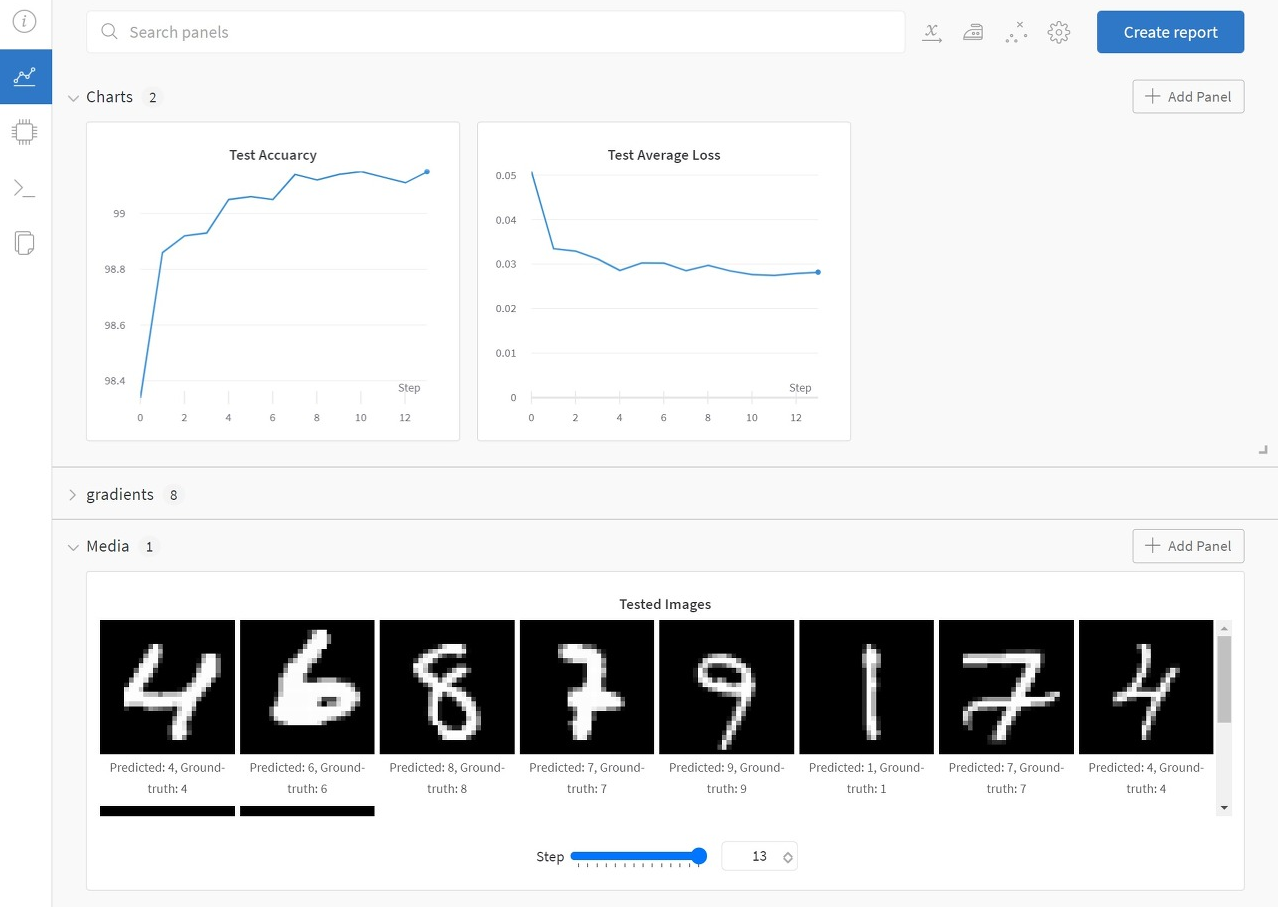